# Import dependencies

In [50]:
import requests
import json
import pandas as pd
import csv
import os
import math
import threading
import concurrent
from concurrent.futures import ThreadPoolExecutor
from time import sleep
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from collections import Counter

pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set_style("darkgrid")

# Load the data

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/dategenius')

Mounted at /content/drive


In [3]:
def load_data(folder_path):
    csv_files = glob.glob(folder_path + "/" + "*.csv")
    dfs = []
    for f in csv_files:
        dfs.append(pd.read_csv(f))

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.drop_duplicates(subset="id", keep="first", inplace=True)
    combined_df = combined_df.reset_index()
    combined_df.drop('index', axis=1, inplace=True)
    return combined_df

Load the data that was crawled by category from 1-10000, found 746635 unique products

In [128]:
origin_df = load_data('data')
all_columns = origin_df.columns
origin_df.head()

,rating_average,url_key,quantity_sold,shippable,thumbnail_height,primary_category_path,original_price,discount_rate,discount,seller_product_id,...,thumbnail_url,impression_info,sku,id,thumbnail_width,review_count,brand_id,brand_name,video_url,is_normal_delivery
0,5.00000,bach-khoa-thu-the-he-moi-tai-ban-2016-p419708,"{'text': 'Đã bán 2', 'value': 2}",True,280,1/2/8322/316/393/853,297000,0,0,217719494,...,https://salt.tikicdn.com/cache/280x280/media/c...,[{'impression_id': 'thanos-product-udPvyI54syS...,1652340276560,419708,280,1,NaN,NaN,NaN,NaN
1,0.00000,nhung-truyen-hay-viet-cho-thieu-nhi-vu-tu-nam-...,NaN,True,280,1/2/8322/316/393/1754,54650,0,0,137943504,...,https://salt.tikicdn.com/cache/280x280/media/c...,[{'impression_id': 'thanos-product-aCvPC8SaiZb...,1386174879413,429450,280,0,NaN,NaN,NaN,NaN
2,0.00000,nhung-guong-mat-lam-thay-doi-the-gioi-harry-ho...,"{'text': 'Đã bán 1', 'value': 1}",True,280,1/2/8322/316/393/1754,27000,11,2970,21296375,...,https://salt.tikicdn.com/cache/280x280/media/c...,[{'impression_id': 'thanos-product-OPexu61wtrN...,3652913255366,445872,280,0,NaN,NaN,NaN,NaN
3,4.80000,nuoc-xit-khoang-evoluderm-150ml-12206-p394685,"{'text': 'Đã bán 62', 'value': 62}",True,280,1/2/1520/1582/5872,138500,7,10000,58602348,...,https://salt.tikicdn.com/cache/280x280/media/c...,[{'impression_id': 'thanos-product-Obye6PqS2tW...,9403980387955,394685,280,14,24921.00000,Evoluderm,NaN,NaN
4,5.00000,ban-ui-kho-electrolux-edi2004-trang-xanh-hang-...,"{'text': 'Đã bán 43', 'value': 43}",True,280,1/2/1882/1946/1993/1995,370000,22,80000,162595980,...,https://salt.tikicdn.com/cache/280x280/ts/prod...,[{'impression_id': 'thanos-product-r9fMaMZQ1in...,3112260881236,444670,280,10,19050.00000,Electrolux,NaN,NaN


In [129]:
all_columns, len(all_columns)

(Index(['rating_average', 'url_key', 'quantity_sold', 'shippable',
        'thumbnail_height', 'primary_category_path', 'original_price',
        'discount_rate', 'discount', 'seller_product_id', 'productset_id',
        'price', 'seller_id', 'badges_new', 'availability',
        'primary_category_name', 'name', 'url_path', 'seller_name',
        'thumbnail_url', 'impression_info', 'sku', 'id', 'thumbnail_width',
        'review_count', 'brand_id', 'brand_name', 'video_url',
        'is_normal_delivery'],
       dtype='object'),
 29)

## Variable description
1. rating_average: average rating of a product.
2. url_key
3. quantity_sold: number of units of the product that have been sold.
4. shippable: whether the product is shippable or not (True/False)
5. thumbnail_height: height (in pixels) of the thumbnail image associated with the product.
6. primary_category_path:  hierarchical path or category structure to which the product belongs.
7. original_price: original price of the product before any discounts.
8. discount_rate: percentage discount applied to the product.
9. discount: actual discount amount in the currency of the dataset. (VND)
10. seller_product_id:  unique identifier assigned to the product by the seller.
11. productset_id: identifier associated with a group or set of related products.
12. price: current price of the product after any discounts have been applied.
13. seller_id: unique identifier of the seller.
14. badges_new:
15. availabbility: availability status of the product (1, 2, 3, 4)
16. primary_category_name: name of the primary category to which the product belongs.
17. name: name of product.
18. url_path: url_path to the product.
19. seller_name: name of the seller.
20. thumbnail_url: URL of the thumbnail image associated with the product.
21. impression_info:
22. sku: unique identifier assigned to a specific product variant.
23. id: unique identifier associated with the product.
24. thumbnail_width: width (in pixels) of the thumbnail image associated with the product.
25. review_count: total number of customer reviews available for the product.
26. brand_id: unique identifier associated with the brand of the product.
27. brand_name: name of the brand.
28. video_url: URL of a video associated with the product.
29. is_normal_delivery: indicate whether the product is delivered through normal delivery.

# Take a first look

## Overview of the data

First thing to do is look at the data information, which will provide us the number of rows, columns, information of any specific column such as name, non-null count, datatype
see data types and null percentage.

Then I show the percentage of null values per column, we should have better understanding about number of null values compared to total entries

In [130]:
origin_df.info(), (origin_df.isnull().sum() / len(origin_df)) * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746635 entries, 0 to 746634
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   rating_average         746635 non-null  float64
 1   url_key                746635 non-null  object 
 2   quantity_sold          391218 non-null  object 
 3   shippable              746635 non-null  bool   
 4   thumbnail_height       746635 non-null  int64  
 5   primary_category_path  746635 non-null  object 
 6   original_price         746635 non-null  int64  
 7   discount_rate          746635 non-null  int64  
 8   discount               746635 non-null  int64  
 9   seller_product_id      746635 non-null  int64  
 10  productset_id          746635 non-null  int64  
 11  price                  746635 non-null  int64  
 12  seller_id              746635 non-null  int64  
 13  badges_new             746635 non-null  object 
 14  availability           746635 non-nu

(None,
 rating_average           0.00000
 url_key                  0.00000
 quantity_sold           47.60251
 shippable                0.00000
 thumbnail_height         0.00000
 primary_category_path    0.00000
 original_price           0.00000
 discount_rate            0.00000
 discount                 0.00000
 seller_product_id        0.00000
 productset_id            0.00000
 price                    0.00000
 seller_id                0.00000
 badges_new               0.00000
 availability             0.00000
 primary_category_name    0.00000
 name                     0.00000
 url_path                 0.00000
 seller_name              0.00000
 thumbnail_url            0.00000
 impression_info          0.00000
 sku                      0.00000
 id                       0.00000
 thumbnail_width          0.00000
 review_count             0.00000
 brand_id                15.94862
 brand_name              15.94889
 video_url               91.77697
 is_normal_delivery      99.76146
 dtype:

For better visualization, I plot a bar graph that show columns null percentage

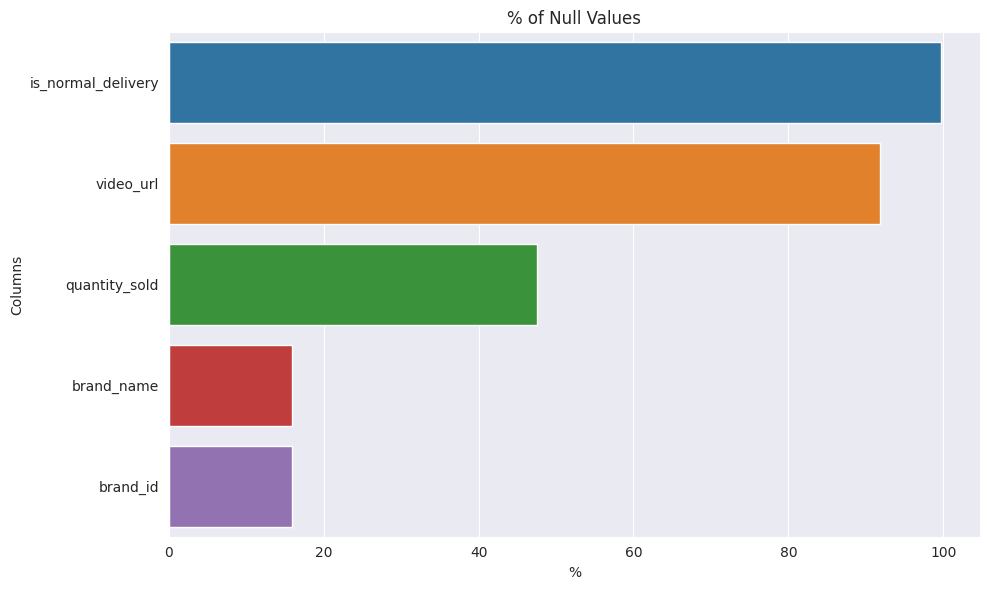

In [131]:
def plot_null(df):
    # Calculate the percentage of null values for each column
    percentage_null = (df.isnull().sum() / len(df)) * 100
    percentage_null = percentage_null.sort_values(ascending=False)
    percentage_null = percentage_null[percentage_null > 0]

    # Create a bar chart using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=percentage_null, y=percentage_null.index)

    # Set chart information
    plt.title("% of Null Values")
    plt.xlabel("%")
    plt.ylabel("Columns")
    plt.tight_layout()
    plt.show()

plot_null(origin_df)

In [132]:
origin_df['is_normal_delivery'].unique()

array([nan, False], dtype=object)

- Almost values in `video_url` and `is_normal_delivery` column are null, we can drop these columns, but we better make use of them
- `video_url`: Map not null value to 1, null to 0
- In `is_normal_delivery`, just 2 two kind of values, for the "nan" value I will map it to 1, "False" will be mapped to 0

In [133]:
df = origin_df.copy()
df['video_url'] = df['video_url'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['is_normal_delivery'] = df['is_normal_delivery'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [134]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating_average,746635.00000,1.52537,2.18929,0.00000,0.00000,0.00000,4.50000,5.00000
thumbnail_height,746635.00000,280.00000,0.00000,280.00000,280.00000,280.00000,280.00000,280.00000
original_price,746635.00000,897712.64661,6796075.78353,930.00000,70304.50000,160000.00000,390000.00000,1412000000.00000
discount_rate,746635.00000,6.67144,12.97569,0.00000,0.00000,0.00000,7.00000,99.00000
discount,746635.00000,62449.43452,483412.48057,-37800.00000,0.00000,0.00000,8000.00000,57500000.00000
seller_product_id,746635.00000,152256336.45019,71398651.29986,2230.00000,97052729.50000,167457618.00000,204958273.00000,263272863.00000
productset_id,746635.00000,1830.36363,1362.51825,26.00000,264.00000,1557.00000,2815.00000,5189.00000
price,746635.00000,835263.21209,6707947.85947,500.00000,67000.00000,149000.00000,350000.00000,1412000000.00000
seller_id,746635.00000,140167.37572,107068.84070,1.00000,34429.00000,135371.00000,240291.00000,338846.00000
availability,746635.00000,1.01108,0.18113,1.00000,1.00000,1.00000,1.00000,4.00000


When looking at the data description, we can see that there are outliers. In `quantity_sold`, `price`, ...

This is reasonable when dealing with such a big dataset

## Drop unuse columns

When looking into the dataset, we see that values of the `impression_info`, `badges_new` and `quantity_sold` are store inside brackets, let's investigate what are inside!

In [135]:
sample = df.iloc[5000]
print(sample['impression_info'])
print(sample['badges_new'])
print(sample['quantity_sold'])

[{'impression_id': 'thanos-product-hVPSNjmYsLpY0h69', 'metadata': {'rating_average': 0, 'price': 139000, 'seller_product_id': 52705097, 'reviews_count': 0}}]
[{'placement': 'delivery_info', 'type': 'delivery_info_badge', 'code': 'delivery_info_badge', 'text': 'Giao thứ 2, ngày 19/06'}, {'placement': 'under_price', 'type': 'asa_reward_html', 'code': 'asa_reward_html_badge', 'text': 'Tặng tới 3 ASA (758 ₫)<br/>≈ 0.5% hoàn tiền', 'text_color': '#808089'}]
nan


Can easily see that fields in `impression_info` are already exist, impression_id is not really useful, and fields in `badges_new` are not useful as well
-> Drop

We will keep field `value` in column `quantity_sold`

In [136]:
df['quantity_sold'] = df['quantity_sold'].apply(lambda x: eval(x)['value'] if pd.notnull(x) else 0)

### Drop unused columns

In [137]:
# Remove columns seem to be useless
columns_to_drop = ['url_key', 'thumbnail_height', 'brand_name', 'impression_info', 'badges_new',
                   'primary_category_path', 'seller_name', 'name', 'thumbnail_url',
                   'id', 'url_path', 'sku', 'thumbnail_width']
df = df.drop(columns_to_drop, axis=1)
df.iloc[0]

rating_average                         5.00000
quantity_sold                                2
shippable                                 True
original_price                          297000
discount_rate                                0
discount                                     0
seller_product_id                    217719494
productset_id                              252
price                                   297000
seller_id                                  197
availability                                 1
primary_category_name    Kiến thức - Bách khoa
review_count                                 1
brand_id                                   NaN
video_url                                    0
is_normal_delivery                           0
Name: 0, dtype: object

## Process null values
Useful columns are kept, let's dealing with null values before moving to visualization

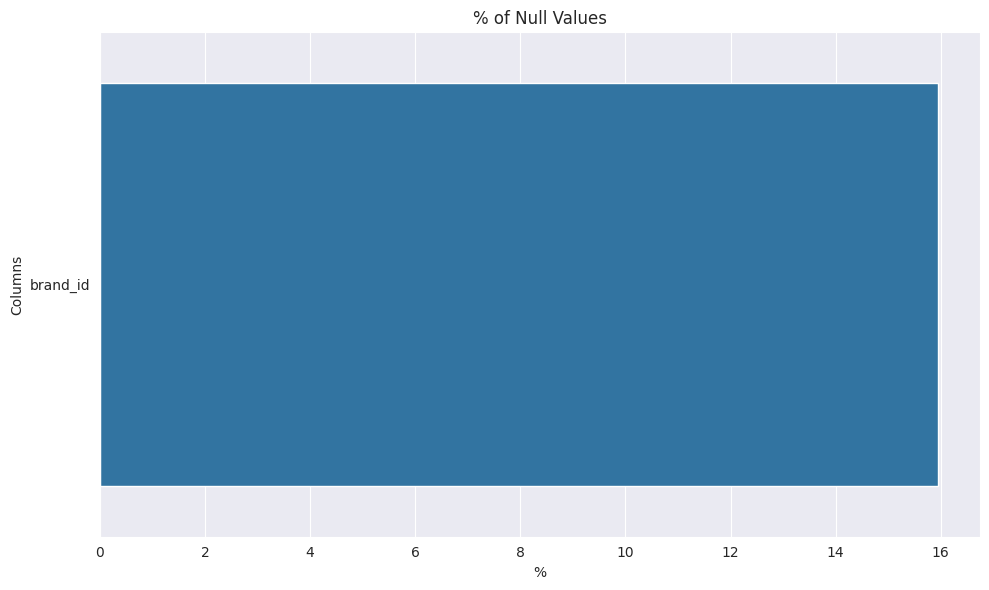

In [138]:
plot_null(df)

In [139]:
# Fill branch_id = 0 for null values
df['brand_id'] = df['brand_id'].apply(lambda x: 0 if pd.isnull(x) else x)
# Add additional column for future useage
df['have_brand'] = df['brand_id'].apply(lambda x: 1 if x != 0 else 0)

Only `brand_id` is having null values, after filling them with 0, let's review the dataframe info again

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746635 entries, 0 to 746634
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   rating_average         746635 non-null  float64
 1   quantity_sold          746635 non-null  int64  
 2   shippable              746635 non-null  bool   
 3   original_price         746635 non-null  int64  
 4   discount_rate          746635 non-null  int64  
 5   discount               746635 non-null  int64  
 6   seller_product_id      746635 non-null  int64  
 7   productset_id          746635 non-null  int64  
 8   price                  746635 non-null  int64  
 9   seller_id              746635 non-null  int64  
 10  availability           746635 non-null  int64  
 11  primary_category_name  746635 non-null  object 
 12  review_count           746635 non-null  int64  
 13  brand_id               746635 non-null  float64
 14  video_url              746635 non-nu

Dataset are now good for visualizing

# Dive deeper insight

## Explore category columns
To know the balance/imbalance of the dataset, We will visualize the quantity among values of category columns to see the differences

In [142]:
def bar_plot(df, col_name):
    # count number of categorical variable(value/sample)
    count = df[col_name].value_counts()

    # visualize
    plt.figure(figsize = (9,3))
    sns.barplot(x=count.index, y=count)
    plt.xticks(count.index, count.index.values)
    plt.ylabel("Frequency")
    plt.title(col_name)
    plt.show()
    print("{}: \n {}".format(col_name, count))

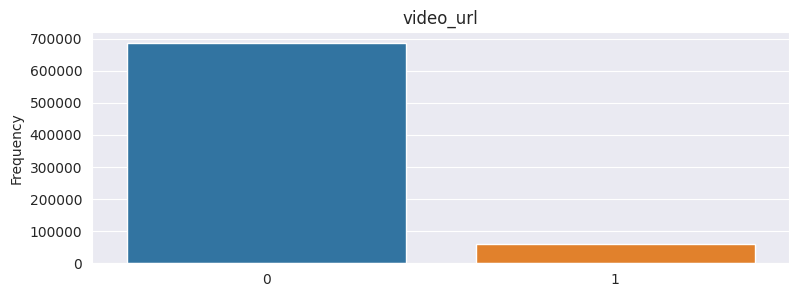

video_url: 
 0    685239
1     61396
Name: video_url, dtype: int64


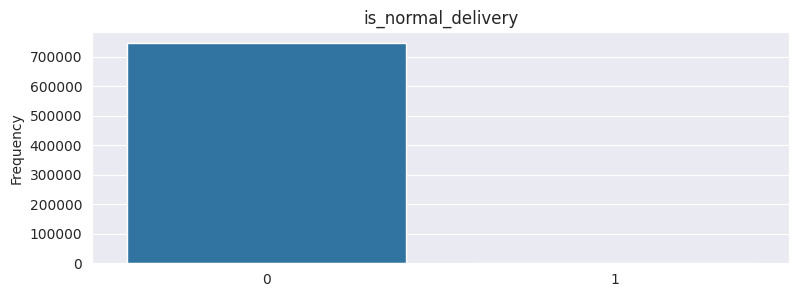

is_normal_delivery: 
 0    744854
1      1781
Name: is_normal_delivery, dtype: int64


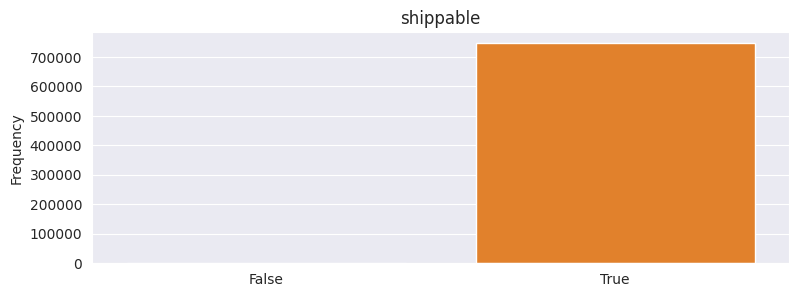

shippable: 
 True     746628
False         7
Name: shippable, dtype: int64


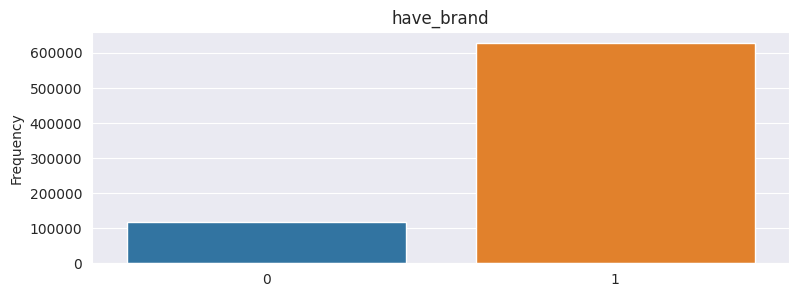

have_brand: 
 1    627557
0    119078
Name: have_brand, dtype: int64


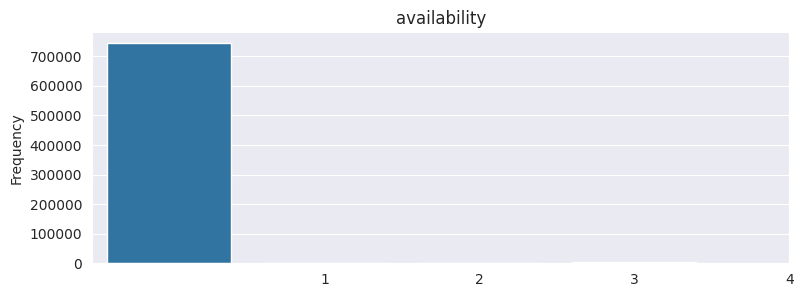

availability: 
 1    743838
4      2683
3       109
2         5
Name: availability, dtype: int64


In [143]:
cat_col = ["video_url", "is_normal_delivery", "shippable", "have_brand", 'availability']
for c in cat_col:
    bar_plot(df, c)

After seeing these columns, we can conclude that the dataset is currently imbalance. The next step we can think of is removing outliers

## Outliers removing

Outlier removing is a crucial step because:
- Outliers can potentially distort our analysis, leading to skewed results and misleading interpretations.
- Outliers can significantly affect statistical measures such as the mean and standard deviation. Removing outliers helps ensure that these measures accurately represent the majority of the data.
- Outliers can distort the shape and interpretation of the data distribution. Removing outliers helps reveal the underlying distribution and allows for more accurate analysis.
- By removing outliers, we can enhance the overall data quality, ensuring that our analysis is based on accurate and reliable information.


Our strategy is to detect outliers is  using IQR, by removing all values that smaller than Q1-1.5*IQR and all values bigger than Q3+1.5IQR.

Read more at https://www.analyticsvidhya.com/blog/2022/09/dealing-with-outliers-using-the-iqr-method/

In [144]:
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)

    return multiple_outliers

In [145]:
numerical_cols = ['quantity_sold', 'price', 'review_count', 'discount', 'original_price', 'discount_rate']
df.loc[detect_outliers(df, numerical_cols)]

,rating_average,quantity_sold,shippable,original_price,discount_rate,discount,seller_product_id,productset_id,price,seller_id,availability,primary_category_name,review_count,brand_id,video_url,is_normal_delivery,have_brand
4,5.00000,43,True,370000,22,80000,162595980,163,290000,212607,1,Bàn ủi khô,10,19050.00000,0,0,1
30,4.80000,550,True,269000,38,102220,58496690,248,166780,48511,1,Sách tham khảo cấp III,124,0.00000,0,0,0
31,5.00000,208,True,62000,40,25000,19884917,248,37000,48511,1,Sách tham khảo cấp II,35,0.00000,0,0,0
34,4.50000,62,True,49000,35,17150,73316442,248,31850,48511,1,Sách tham khảo cấp III,6,0.00000,0,0,0
36,4.50000,292,True,159000,38,60420,19843676,248,98580,48511,1,Sách tham khảo cấp III,41,0.00000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744556,0.00000,0,True,950000,40,380000,252633557,2033,570000,1227,1,Nón cho bé,0,153769.00000,0,0,1
744748,0.00000,0,True,950000,40,380000,252633911,2033,570000,1227,1,Nón cho bé,0,153769.00000,0,0,1
745374,0.00000,0,True,950000,40,380000,252633872,2033,570000,1227,1,Nón cho bé,0,153769.00000,0,0,1
746281,0.00000,1,True,900000,50,450000,161031089,2361,450000,175415,1,Kệ chữ A,0,4648365.00000,1,0,1


Number of outliers are 75599, it's 10% if compare to total records (746635)

After removing outliers, check the unique value of category column again

In [146]:
df = df.drop(detect_outliers(df, numerical_cols),axis = 0).reset_index(drop = True)
for c in df.columns:
    print(c, len(df[c].unique()))

rating_average 37
quantity_sold 2180
shippable 1
original_price 28559
discount_rate 91
discount 8441
seller_product_id 670036
productset_id 1689
price 30743
seller_id 22498
availability 4
primary_category_name 2106
review_count 659
brand_id 15290
video_url 2
is_normal_delivery 2
have_brand 2


In [147]:
# Dropping shippable column because its values are all True
df = df.drop('shippable', axis=1)

## Explore the Rating
Ratings are often considered a crucial performance indicator, reflecting customers' satisfaction and perception. By examining this specific variable, you gain an initial understanding of the overall quality or satisfaction level.

Ratings can offer insights into customer preferences and behavior. Exploring the distribution of ratings can provide information about the customers' general sentiment.

### Overall rating per product
We started by exploring the `rating_average` column, which indicated the average rating of the products.



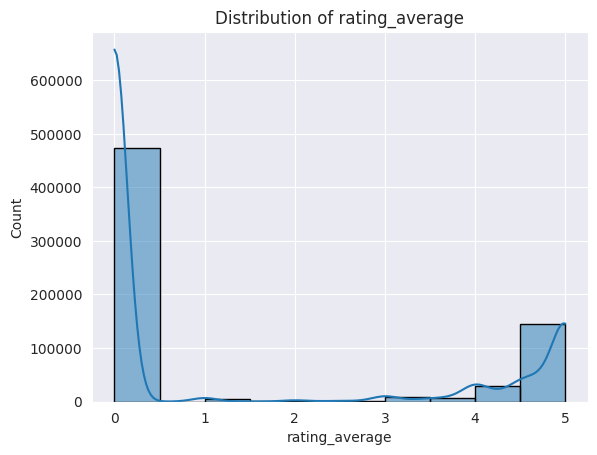

In [148]:
def plot_hist(df, field, title, bins=10, kde=True):
    sns.histplot(df[field], bins=bins, edgecolor='k', kde=kde)
    plt.xlabel(field)
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_hist(df, 'rating_average', 'Distribution of rating_average')

Surprisingly, a significant proportion of products, most of products had a rating of 0. Just a small portion of products had a rating of 5. Products with ratings from 1 to 4 were relatively scarce.

This distribution said that most of customers are disasitification with the products, a smaller portion of customer are very sastify.

### Explore the rating_average distribution by seller_id
After examining the overall distribution of ratings, I decided to explore how the ratings varied across different sellers. Grouping the data by the `seller_id` column, with the aim to gain insights into the rating patterns specific to each seller.

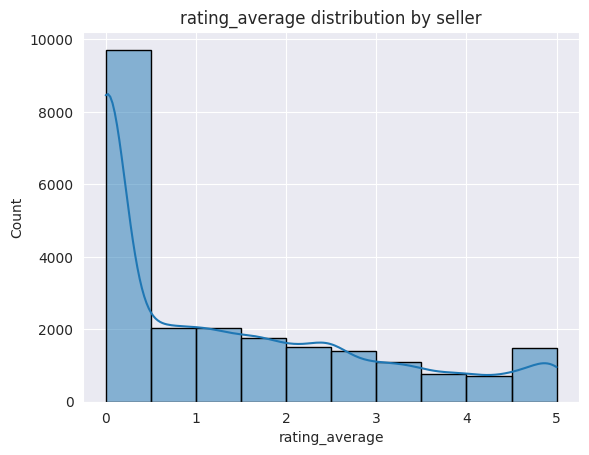

In [149]:
avg_rating_per_seller = df.groupby('seller_id')['rating_average'].mean().reset_index()
sorted_avg_rating_per_seller = avg_rating_per_seller.sort_values('rating_average', ascending=False)
plot_hist(avg_rating_per_seller, 'rating_average', 'rating_average distribution by seller')

Observed that around 8,000 sellers had a rating of 0. This indicated that a significant portion of sellers received no ratings from customers.

Furthermore, we found that approximately 2,000 sellers had ratings of 1,  and decreasing gradually to 5. Indicating poor customer satisfaction with their products or services.

By examining the rating distribution per seller_id, we gained valuable insights into how different sellers were rated by customers. This information highlighted the diversity in customer satisfaction levels and the varying experiences customers had with different sellers.

### Explore the rating_average distribution by seller_id
Similarly to the one I did previous, this time we'll deal with `productset_id` instead of `seller_id` to gain more insight about the data relating to the `rating_average`

In the context of rating and seller, we can see that just few seller are really loved by customers, most of the sellers are rated 0

So if we measure the rating for every productset, is there any difference?

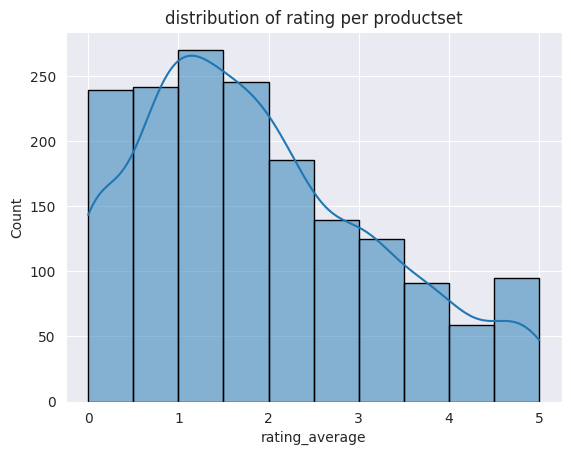

In [150]:
avg_rating_per_productset = df.groupby('productset_id')['rating_average'].mean().reset_index()
sorted_avg_rating_per_productset = avg_rating_per_seller.sort_values('rating_average', ascending=False)
plot_hist(avg_rating_per_productset, 'rating_average', 'distribution of rating per productset')

 Surprisingly, this distribution is just a little bit right skewed. The majority of ratings fall within the range of 1, 2, and 3, indicating a moderate level of satisfaction for the products.

 Through this graph, we found that certain product sets had a higher average rating compared to others. This indicated that customers generally had a more positive perception of products belonging to those particular sets. On the other hand, some product sets had lower average ratings, mean that customers were less satisfied with products in those sets.

### Explore the realtionship between rating_average and review_count
As an online shopping addicted guy, I'm always take a look at the review section before deciding to buy anything, I will just buy the product which have more positive review than negative review. So I think `review_count` will have certain affect to the `rating_average`.

Let's plot it out!

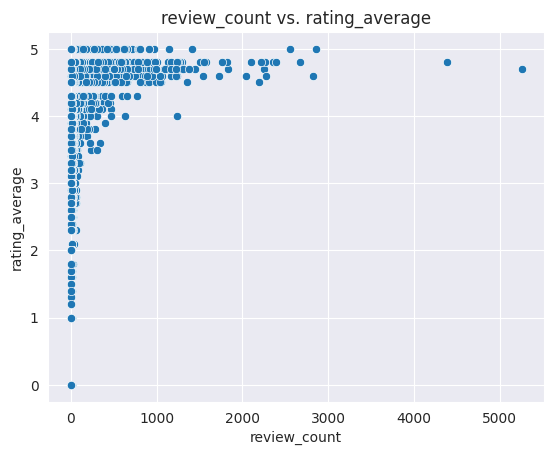

In [151]:
def plot_scatter(df, f1, f2):
    sns.scatterplot(x=df[f1], y=df[f2])
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'{f1} vs. {f2}')
    plt.show()

plot_scatter(df, 'review_count', 'rating_average')

We noticed a fascinating trend - a positive relationship between the average rating and the review count. We can easily see that the `review_count` increase, the `rating_average` tends to be higher and vice versa.
> From my shopping experience, this is what I expected.

### Explore the Correlation Heatmap
Heatmap is one of the graph that I like most due to its ability to provide a holistic view of the dataset, helping me to discover hidden connections, provide a visual representation of the correlation matrix.

<ipython-input-152-89d1844102bd>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt = ".3f")


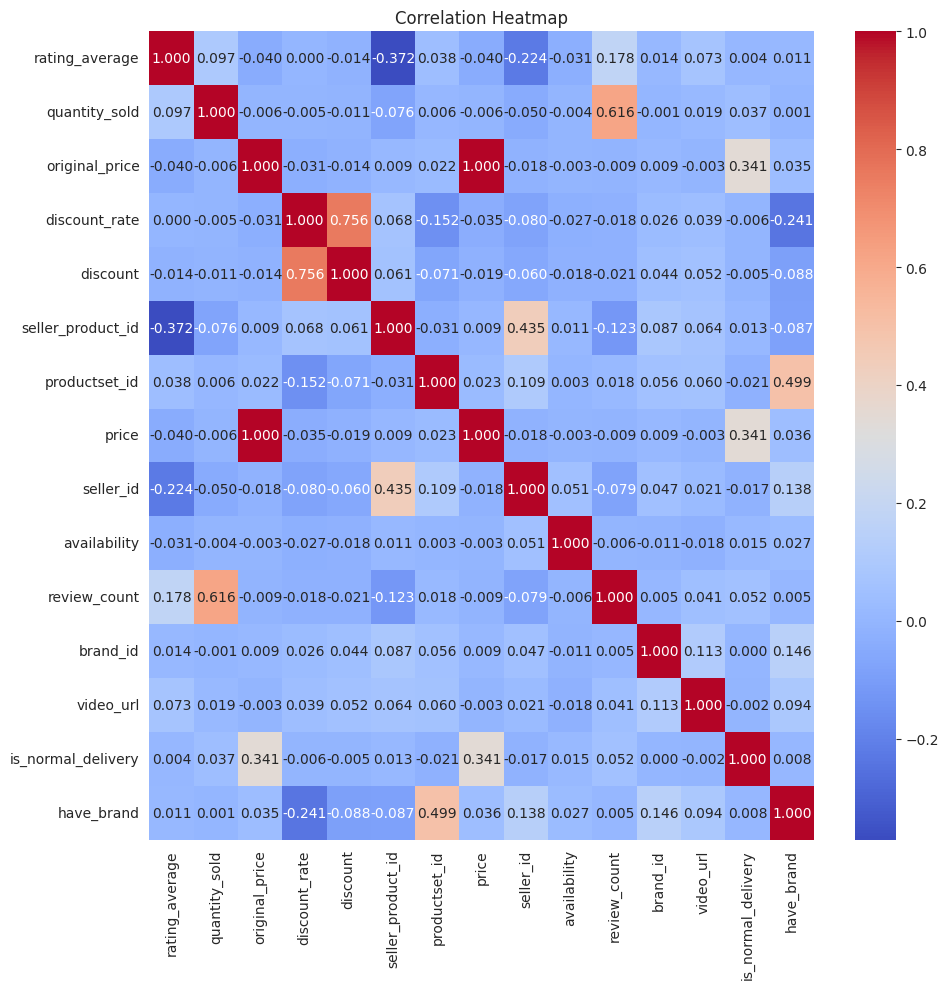

In [152]:
# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt = ".3f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Thanks to Heatmap, we can discover that some pair column is very correlated such as `is_normal_delivery` and `price`, `review_count` and `quantity_sold`, `discount_rate` and `have_branch` (we will not care the column contains `id`)

Let's move on to see how they correlated to each other!

### is_normal_delivery -- price

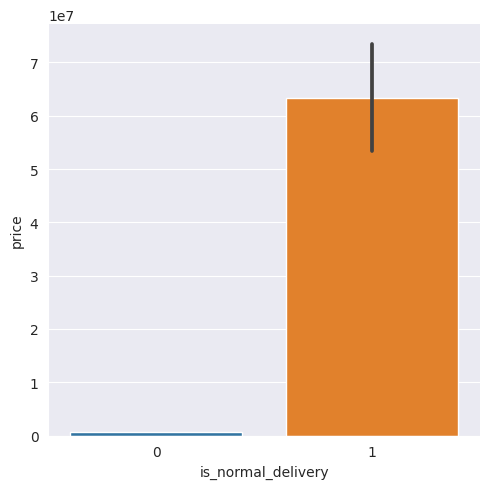

In [153]:
pairs = [['is_normal_delivery', 'price'], ['review_count', 'quantity_sold'], ['have_brand', 'discount_rate']]
sns.catplot(x=pairs[0][0], y =pairs[0][1], data=df, kind='bar')

The graph said that product which is normal delivery tends to has higher price

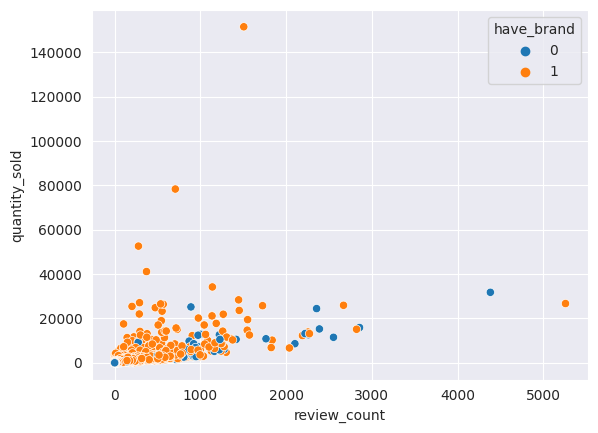

In [154]:
sns.scatterplot(x=pairs[1][0], y =pairs[1][1], data=df, hue='have_brand')
plt.show()

`review_count` and `quantity_sold` are quite linear correlated, I have added `have_branch` factor to see whether it has some affect, but perhaps not!

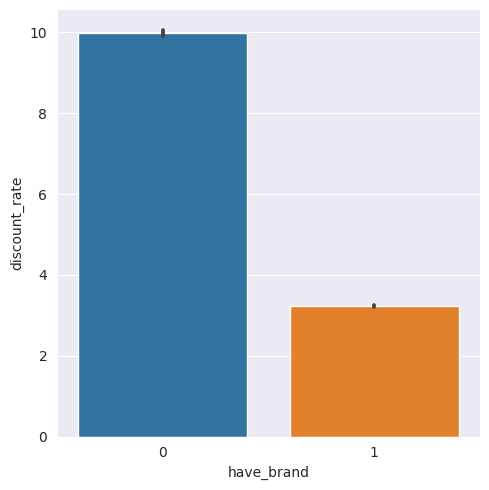

In [155]:
sns.catplot(x=pairs[2][0], y =pairs[2][1], data=df, kind='bar')
plt.show()

From the graph I can say that non-brand product get a higher discount rate